# <p style="text-align: center;">Identifying Types of Pneumonia with Chest Xray Images</p>

### <p style="text-align: center;">Sean Furuta   ,   David Miller   ,   Rakesh Walisheter</p>

## Introduction

Chest X-Ray (CXR) images have been an essential tool to diagnose pneumonia in patients [[Ref-1](#References)]. 

In the wake of the COVID-19 pandemic, A large curated dataset of CXR images for patients with potential pneumonia-infections, and their corresponding lung-secgementation masks has been created by the authors of the referenced paper. This dataset now allows for advanced computer vision techniques to distinguish between the novel COVID-19 and other types of pneumonia.

This study intends to use this CXR Image dataset to build models which can classify a CXR as either Normal, or infected with COVID19 or infected with a non-COVID Pneumonia.

## Executive Summary

To prepare CXR images for modelling a preprocessing pipe with these steps was developed:

1. Histogram equalization
2. Contrast limited adaptive histogram equalization (CLAHE)
3. Local normalization
4. Denoising

To reduce dimensionality while retaining as much relevant information as possible, a feature engineering pipeline was designed with the following steps:

1. Scale Invarient Feature Transform(SIFT) [Ref-3] keypoints detection.
2. Cluster keypoints from SIFT into N-Clusters (N=10 for this study) based on position and size.
3. Use the cluster labels to then calculate summary statistics (mean, variance, standard-deviation) for the Position (x,y) and Size.
4. Texture features using Gray-Level Co-occurance Matrix (GLCM) features.
5. Texture features using Local Binary Patterns.
6. Flatten and normalize each feature-vector to floating point vectors between 0-1.
7. Concatenate into the final feature vector.

We developed 4 distinct models to evaluate the image classification task:

| Model | Accuracy |
| --- | --- |
| Logistic Regression | .543 |
| Gradient Boosted Classifier | .671 |
| RESNET50 | .886 |
| CovXNET | .905 |

## Data

### Dataset Description

The researchers of Qatar University have compiled the COVID-QU-Ex dataset, which consists of 33,920 chest X-ray (CXR) images including:
- 11,956 COVID-19
- 11,263 Non-COVID infections (Viral or Bacterial Pneumonia)
- 10,701 Normal  

Ground-truth lung segmentation masks are provided for the entire dataset. This study utilizes both lung and infection segmentation to detect, localize and quantify COVID-19 infection from X-ray images.

We expect some level of data preparation necessary to reach a suitable modeling dataset based on the following factors:
- Lateral x-rays do not contain lung segmentations.
- Portable x-ray images are low quality.
- Some images are obfuscated by medical instruments.
- Images are unevenly illuminated which is exacerbated with enhancement. 
- Features of interest are not immediately evident to a visual check. 

### Image Preprocessing

The dataset contains CXR-images collected from a diverse group of patients and situations and so the quality and structure of images are not uniform. 

##### Contrast Enhancement

CXR-images in the dataset were observed to be low-contrast, needing a boost to help with identifying features. 

Two methods of contrast enhancement were tried to boost contrast-

1. Histogram Equalization : In this method , the overall intensity-distribution of the image is spread out across the range of intensities. A sample of Histogram equalization is shown below. This mode of enhancement is not ideal since it does not boost the detailed features and smaller regions in the image which is essential for feature detection.
    
2. __Contrast Limited Adaptive Histogram Equalization (CLAHE)__: CLAHE is an adaptive histogram-equalization process which enhances finer contrast changes within smaller regions in the image and is included in the preprocessing pipe.

Histogram Equalization to boost Contrast

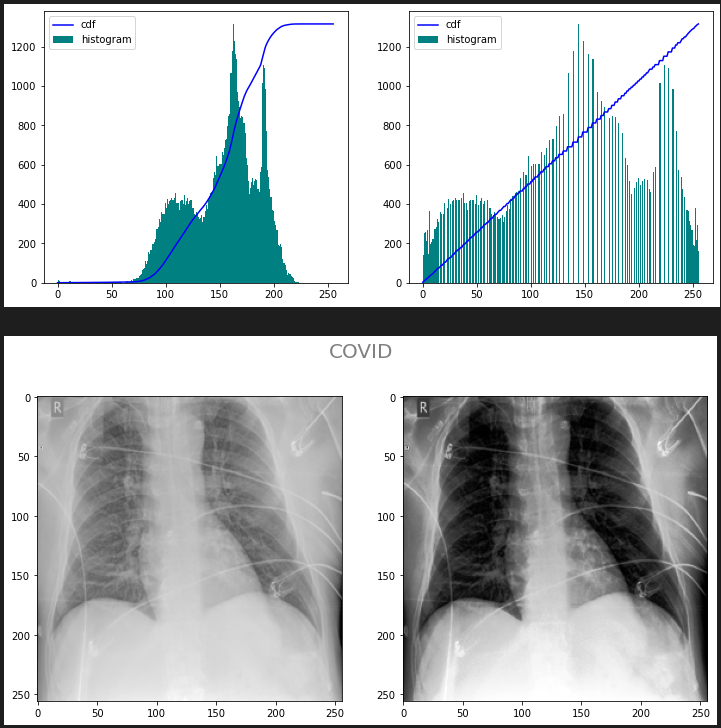

In [12]:
from IPython.display import Image, display
Image(filename='./screenshots/histeq.png') 

CLAHE Enhancement

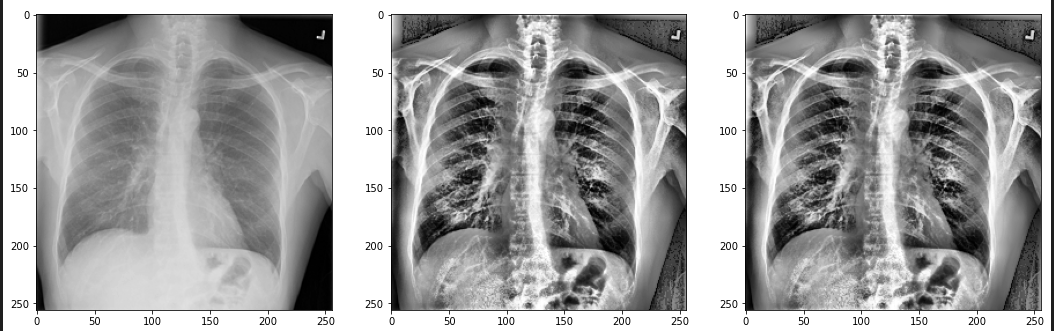

In [3]:
Image(filename='./screenshots/clahe.png') 

### Local Normalization

The results of CLAHE enhancement show fine-details in the lung-segment. But the dominating features like the lung-walls, bone-structure and the negative-space are also distinctively enhanced after this process. __Local Normalization__ is intended to suppress the power of these features and provide a more uniform illumination to the image. The process for LN is shown below with a sample of how the process morphs images.

Algorithm for Local Normalizations [[Ref-2](#References)]

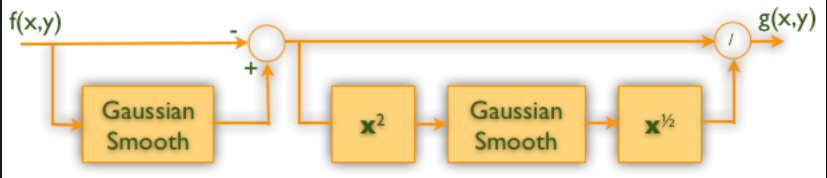

In [4]:
Image(filename='./screenshots/ln_alg.png') 

Sample of how Local Normalization morphs images

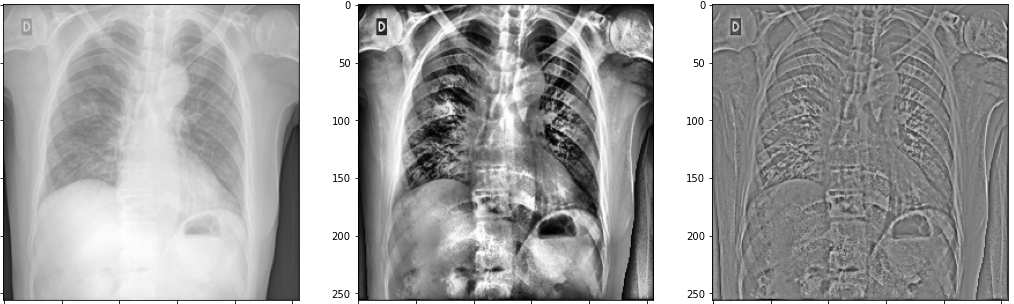

In [5]:
Image(filename='./screenshots/ln_sample.png') 

### Denoising and Lung Masking

Initial image preprocessing is bound to introduce noise into the images. OpenCV-`fastNlMeansDenoising` function is being used to remove noise. `fastNlMeansDenoising` accepts a filter-strength parameter `h`. A high `h` results in noise being removed but also finer image features being lost. So a balanced `h` is required to ensure image-data is preserved.

Further, the dataset also provides lung-masks to allow modeling tasks to focus on the lung-segment. This step is applied as the last step of preprocessing. 

PreProcessing Pipe

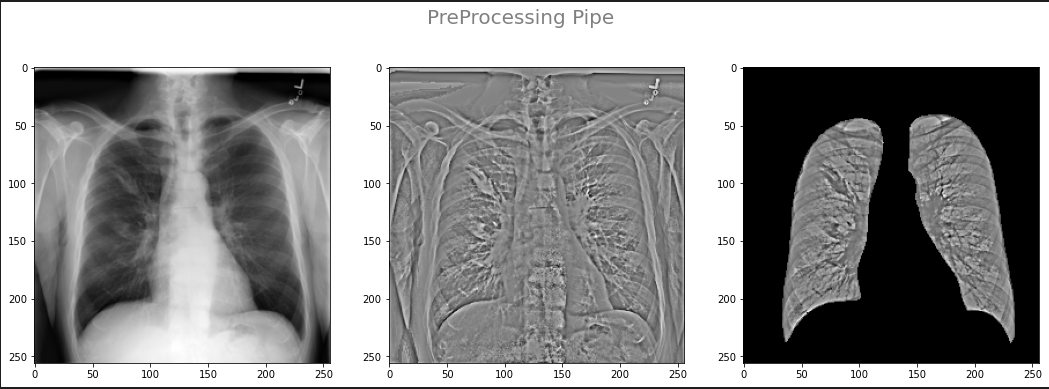

In [6]:
Image(filename='./screenshots/prep.png') 

## Feature Engineering

The dataset of CXR-images contain 256x256 resolution images, which results in an approximately 65k sized feature-set if used as is - a high-dimensionality problem, since our dataset consists of approximately 20k records. Consequently, a suite of feature-extraction steps are evaluated and these steps were selected for the pipeline:

1. Scale Invarient Feature Transform(SIFT) [[Ref-3](#References)] keypoints detection.

2. Cluster keypoints from SIFT into N-Clusters (N=10 for this study) based on position and size information from the keypoint. Use the cluster labels to then calculate summary statistics (mean, variance, standard-deviation) for the Position (x,y) and Size dimensions for the cluster. 

3. Texture features using Gray-Level Co-occurance Matrix (GLCM) features.

4. Texture features using Local Binary Patterns.

5. Each of these feature-vectors are flattened and normalized to be a floating point vectors between 0-1.

6. Concatenate to get the final feature vector.

Each of these steps are described below in brief.

### SIFT Keypoint Detection

SIFT features are suitable for matching similar objects in different scenes, regardless of their scale and orientation. A meaningfully large number of keypoints can be extracted from even low resolution images, which is desirable for this study. Below is a sample of an image from this dataset and keypoints detected from the image with SIFT.

A few points to note:

- There are a few large sized keypoints which seem to correspond to the negative-space between ribs which seem to appear as a blob in the image. These keypoints might not be appropriate to the model and have been filtered out.

- Keypoints detected toward the edge of the lung-segment also are questionable but they are not filtered at this point.

- Finer keypoints in the interior of the lung-segment and which lie in distinct clusters are of interest to this study.

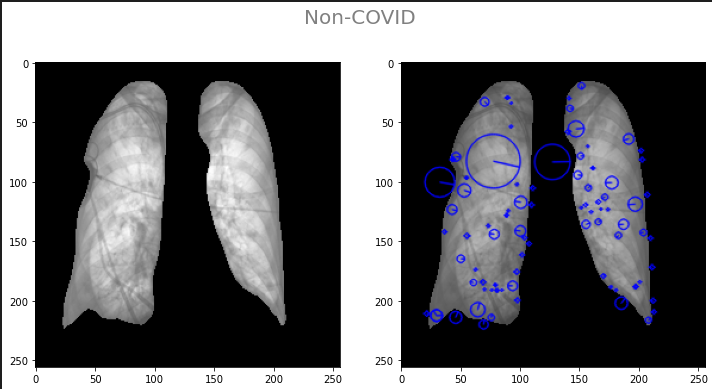

In [7]:
Image(filename='./screenshots/sift.png') 

### Clustering Keypoints - Gaussian Mixture Models

Given a collection of keypoints extracted using SIFT, the dimensionality of these keypoints are still prohibitively high. To further reduce dimensionality this study uses Gaussian Mixtures based clustering to classify keypoints into N-clusters (N=10 for this study; N determines the eventual feature vector dimensionality). Each cluster is defined by its X,Y position and the size associated with its keypoints. The logical assumption then is that a collective statistic defining distributions of the features for all points in a given cluster can be used as features for the cluster itself. 

For this study, the mean, variance, standard deviation of each keypoint features (x, y, size) is evaluated and normalized to obtain the final feature vector. Below is a representation of how keypoints are clustered.

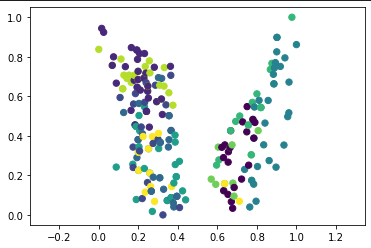

In [8]:
Image(filename='./screenshots/gmm.png') 

### Gray-Level Co-occurance Matrix(GLCM) Texture Features

GLCM is a method to detect textures in an image based on how often local repetitions in pixel values recur throught the image. Textures are important to this study due to the simple assumption is that small-sized features representing local lung-tissue infections can appear across the lung-field and can be pretty similar in texture. Several properties from GLCM are evaluated and can be used to colletively represent the texture of the image. 

GLCM properties like contrast, dissimilarity, homogeneity, energy, correlation, ASM and evaluated for each image. These properties indicate the relative correlations and dissimilarities between random pixel regions chosen from different parts of the image.

### Local Binary Pattern (LBP) Features

Local Binary Pattern (LBP) [[Ref-4](#References)] is an operator to label a pixel as a threshold-measure of all pixels in its neighborhood. The simplicity of this operator results in it being used widely as a texture operator. Screenshot below shows a representation of the operator referenced from linked sources and a sample image and it's LBP pattern information.

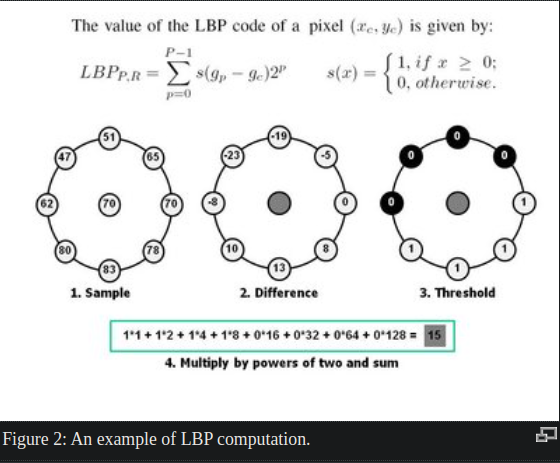

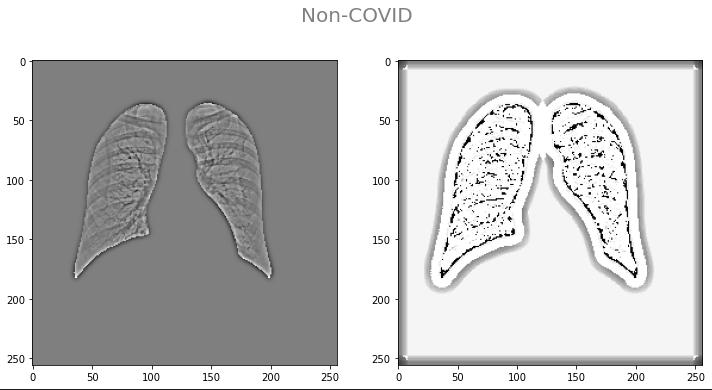

In [20]:
display(Image(filename='./screenshots/lbp_alg.png'), Image(filename='./screenshots/lbp.png'))

#### A Note on Other Features

When studying this dataset, other features were considered but were not included in the feature-pipeline. This is a quick summary of such features and why they were not included,

1. Edge, Line, Corner, Histogram of Oriented Gradients Detectors
This collection of features were considered, but it quickly became evident that due to the nebulous nature of features in a CXR image, it was unlikely that any edges, corners or lines would make sense to identify and use in processing CXR images.

2. Scikit's SimpleBlobDetector
This feature was evaluated to identify keypoints in the image corresponding to blobs and it did not work as intended. The hyperparameters for SimpleBlobDetector seemed to be biased toward regular shapes such as circles/ellipsoid, straight lines, points etc. This might not have been well suited for the rather nebulous properties of CXR images (same as above).

3. Fourier Magnitude Spectrum filtering, Laplace Pyramids and Gabor Filters. 
In CXR images, the ribcage is prominent and does not add value to this study. These 3 options were evaluated to filter out the ribs in the lung-segment. But the outcome would remove too many details from lung-segment itself leading to lost data. There was no evident way forward to utilize these features. 

## Models

### Modeling Framework

We developed 4 distinct models to evaluate the image classification task.  

1. Logistic Regression (baseline)
2. Gradient Boosted Classifier
3. RESNET50
4. CovXNET

The architecture and results of these models are discussed in further detail below.

### Logistic Regression

We developed a simple Logistic Regression model to establish baseline perrformance for comparison against more sophisticated models discussed below. Because this modeling framework does not have built-in handling for NaN values, we simply removed all observations that contained NaN values in any feature vector (approximately 800 of 21,000 total observations).

Using the cross-validation framework discussed above, our Logistic Regression baseline yielded accuracy of 54.3%.

### Histogram Based Gradient Boosted Classifier

As the next step of model for a more sophisticated classification method, the Scikit-learn's Histogram-based Gradient Boosting Classification was used. As a first step a model wth default parameters was trained

Using default hyperparameters for the model, the test-accuracy was evaluated at 66%. Screenshots below show the prediction confusion matrix and Precision, Recall, F1 scores for each class and the overall training and test-accuracy.

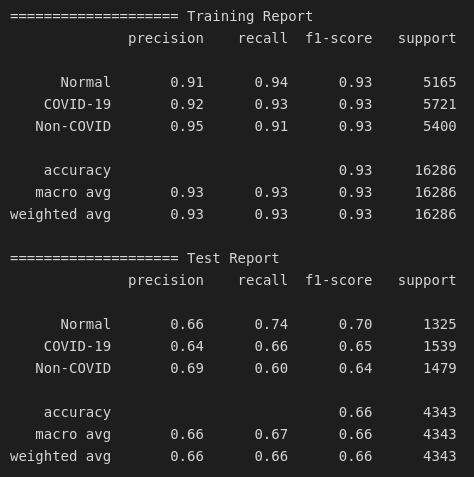

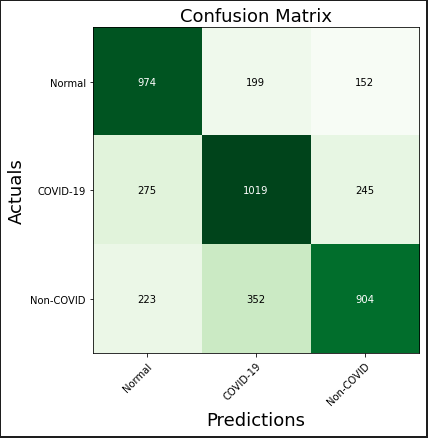

In [14]:
display(Image(filename='./screenshots/m1_score.png'), Image(filename='./screenshots/m1_cm.png') )

#### Cross Validation

As seen in the scores above, a model trained with defaults would overfit on the train data but perform rather poorly on training data. To try to get the model to fit and generalize better, this model is trained again  using a 10-fold cross-validation evaluation. With cross validation, the test-accuracy increased by a percentage point to 67% which was not a significant improvement. 2 possible reasons are postulated for this observation:

1. The model's default parameters were not tuned well enough to allow the model to train efficiently and generalize, or, 
2. The model did not have enough parameters to learn this problem. 

To determine if the first hypothesis had any basis, a tuning of model hyperparameters for the model was evaluated.

#### Hyper Parameter Tuning

Scikit-learn's `HistGradientBoostingClassifier` has these hyperparameters:

- 'max_iter'
- 'learning_rate'
- 'max_depth'
- 'l2_regularization'
- 'max_leaf_nodes'
- 'min_samples_leaf'
- 'max_bins'

A grid-search on each of these hyperparameters was performed to evaluate if the accuracy improved with tuning and if it did, what is the parameter-set which showed improvement. Please refer to screenshots below for details of tuning. 

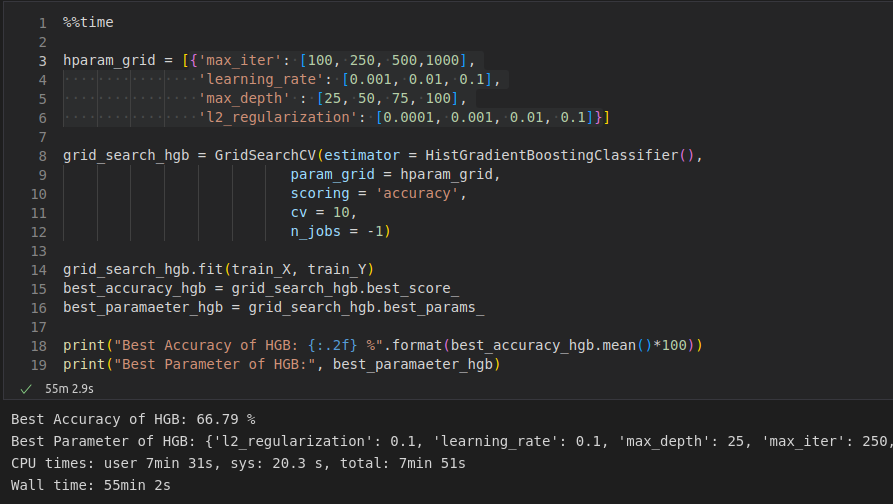

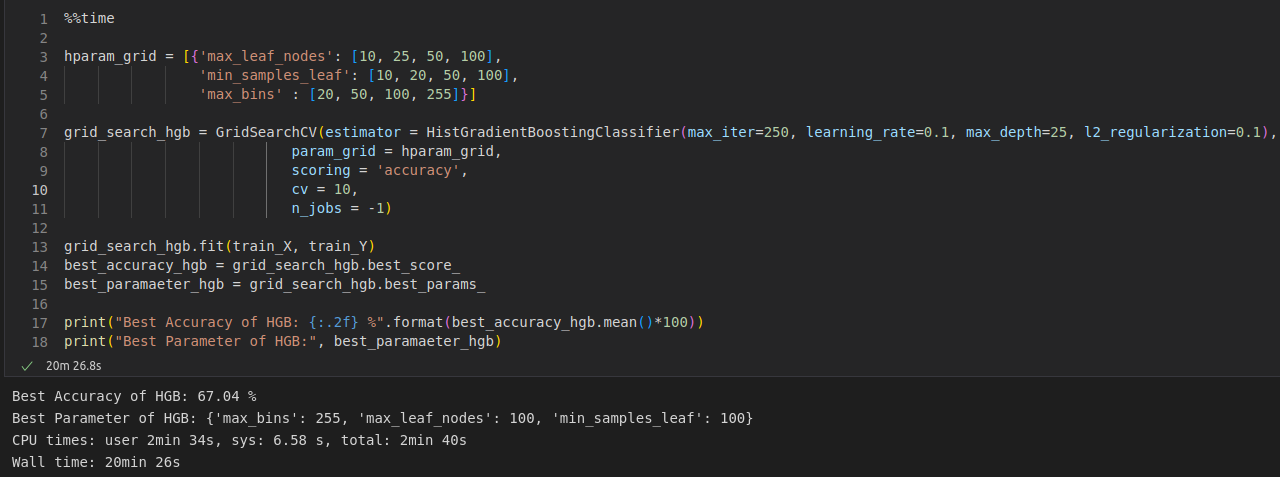

In [15]:
display(Image(filename='./screenshots/tune_1.png'), Image(filename='./screenshots/tune_2.png') )

As can been seen from the results of hyperparam-tuning, the model accuracy did not improve above the cross-validation score. This was evidence against the assumption that the model could perform well with better tuning. Consequently, the rather poor performance of the model can be attributed to the small parameter-space in the Gradient-boosted model. To improve on the model further a neural network based model architecture was evaluated. 

### Convolutional Neural Networks

We trained and evaluated two CNN models [[Ref-5](#References)] using the original lung scans images from our dataset as inputs. The first model is an altered RESNET50 model from keras using the transfer learning weights. The second model is a state of the art CNN developed by Mahmud et al. called CovXNET.

#### RESNET50

Keras offers two pretrained weights and the “NOTOP” weights are the pretrained weights with no top layer. Two additional layers were added as input and output layers for our model because our images are of different sizes and we only have 3 classes. The original images in our dataset are 256x256 and were downscaled to 128x128 to reduce the number of parameters and the input layer transforms our single channel 128x128 to three 128x128 channels to work with the original RGB channels of RESNET50. This is done by duplicating the single channel 3 times and this is a simple work around for adapting pretrained models for grayscale images. However, future work should attempt to apply a more sophisticated method for converting the images. Also, an additional dense output layer with a sigmoid activation function was added to adjust the prediction classes to 3. 


#### CovXNET

Disclaimer: We used code for the construction of the CovXNET model and paper to compare the state of the art results with our own model. We do not claim ownership of the model or the code allocated for the model in the CNN notebook. Please refer to [[Ref-5](#References)] for the code and paper sources.

CovXNET was designed with transfer learning in mind with top layers to be trained on non-covid scans because of the low availablity of the scans during the early stages of the pandemic. Unfortunately, the weights used in the top layer are not available so we simply trained the entire model from our available dataset. However, future work should attempt to use the pretrained weights and apply the new data for proper transfer learning.  

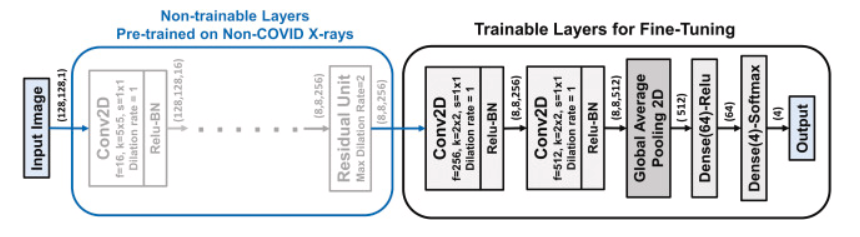

In [16]:
Image(filename='./screenshots/transfer_learning.PNG')

The image below describes the architecture of the CovXNET layers in great detail and points out the main building blocks of the model which are the residual and shifter blocks. These blocks also use depthwise and pointwise convolution to give a breadth of feature extraction and capture features that examine large areas of the scan that often appear in pneumonia.

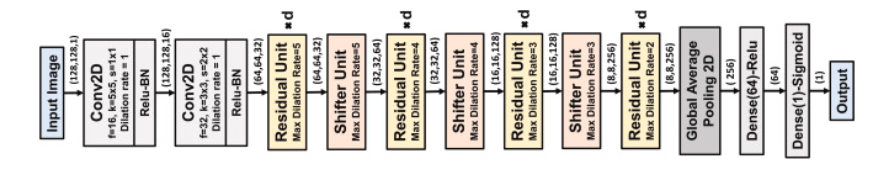

In [17]:
Image(filename='./screenshots/arch.PNG')

#### Input Data

As mentioned above, the input data was transformed to downscale the image to 128x128. The input data was also added to a <code>keras.ImageDataGenerator</code> with a 0.1 height and width shift, a zoom range of 0.2 and a 30 degree rotation shift to generalize the model. The data was also rescaled from 0:255 to 10:1 with a 1/255 transformation. Also, sklearn learn is used to rebalance the classes so no one class is over selected because it is the majority in the training set.

#### Training

Each model go through 60 epochs and use an Adam optimizer to search for the best learning rate for hyperparameter tunnning, The loss function chosen is categorical cross entropy and the metric for comparison is accuracy. Training and validation use a batch size of 16.

#### ResNet50 and CovXNET Results

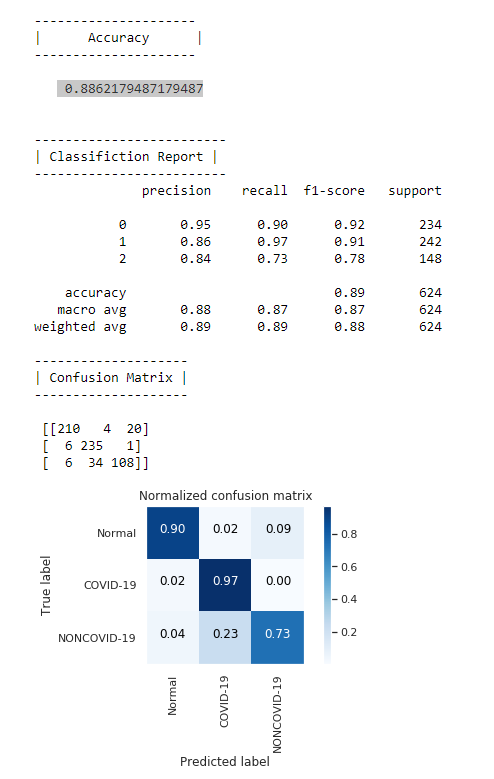

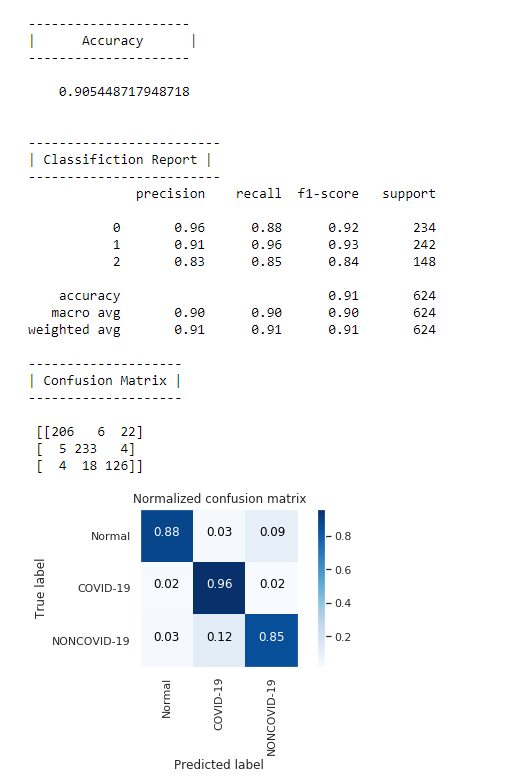

In [18]:
display(Image(filename='./screenshots/resnet_results.PNG'), Image(filename='./screenshots/covxnet_results.PNG'))

## Conclusion and Future Work

Our lack of expertise in the subject matter of CXR-Images, pneumonia in general and COVID19 in particular, meant that we were ill equipped to build the most appropriate features to train the simpler Gradient Booasted Classifers. The larger neural-architecture based models mitigated some of this lack of expertise, but the data that we were working with was not sufficiently large to claim that these classifiers generalize to unseen data.  

IN the future, we intend to work with subject matter experts to understand how they identify and diagnose pneumonia using xrays and adapt their inputs into building better features with the hope that a better, more robust feature vector could improve the accuracy of the non-neural models which are easier and faster to train and iterate. With bigger and more reliably labelled datasets, Neural-architecture based classifiers can also reach better generalizability.

# References

> 1. [Chest radiography and pneumonia in primary care: diagnostic yield and consequences for patient management A. M. Speets, etal](https://erj.ersjournals.com/content/28/5/933#:~:text=CXR%20is%20considered%20the%20gold,symptoms%20(e.g.%20acute%20bronchitis).)</li>

> 2. [Local Normalization](http://bigwww.epfl.ch/sage/soft/localnormalization/#:~:text=The%20local%20normalization%20tends%20to,uneven%20illumination%20or%20shading%20artifacts.)

> 3. [Distinctive Image Features from Scale-Invariant Keypoints - David G. Lowe](https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf)

> 4. [Local Binary Patterns - Matti Pietikäinen etal](http://www.scholarpedia.org/article/Local_Binary_Patterns#:~:text=Local%20Binary%20Pattern%20(LBP)%20is,result%20as%20a%20binary%20number.)

> 5. [Normal Vs Bacterial Vs Viral [ResNet50] and CovXNet](https://www.kaggle.com/code/awsaf49/normal-vs-bacterial-vs-viral-resnet50/notebook)